In [1]:
# install.packages('glmbb')

library(tidyverse)
library(ggplot2)
library(broom)
library(MASS)
library(dplyr)
# library(glmbb)

Warning message:
“package ‘lubridate’ was built under R version 4.4.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




# Data Description
The dataset gives information about customers, their spending habits, and whether they participate in promotions. There are 2240 rows. There are 6 binary variables, and they are `Complain`, and `AcceptedCmp1` to `AcceptedCmp5`. The remaining 23 variables are numeric, except `Dt_Customer` making 29 variables in total.

Source: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis.
The data was provided by Dr. Omar Romero-Hernandez of UC Berkeley.

| **Variable Name**        | **Type**                |  **Variable Description** |
|---------------------------|-------------------------|---|
| **ID**                   | Numeric                | Customer's Unique Identification |
| **Year_Birth**           | Numeric                | Customer's Year of Birth |
| **Education**            | Categorical (Factor)    | Highest Level of Customer's Education |
| **Marital_Status**       | Categorical (Factor)    | Customer's Marital Status |
| **Income**               | Numeric                | Customer's Yearly Household Income (Currency not Indicated) |
| **Kidhome**              | Numeric (Count)                | Number of Children in the Customer's Household |
| **Teenhome**             | Numeric (Count)               | Number of Teenagers in the Customer's Household  |
| **Dt_Customer**          | Date                   | Date of Customer's Enrollment with the Company |
| **Recency**              | Numeric (Count)               | Days Since Last Purchase Made by the Customer  |
| **MntWines**             | Numeric                | Amount Customer Spent on Wines in the Last 2 Years  |
| **MntFruits**            | Numeric                | Amount Customer Spent on Fruits in the Last 2 Years |
| **MntMeatProducts**      | Numeric                | Amount Customer Spent on Meat Products in the Last 2 Years |
| **MntFishProducts**      | Numeric                 | Amount Customer Spent on Fish Products in the Last 2 Years |
| **MntSweetProducts**     | Numeric                | Amount Customer Spent on Sweets in the Last 2 Years |
| **MntGoldProds**         | Numeric                | Amount Customer Spent on Gold in the Last 2 Years |
| **NumDealsPurchases**    | Numeric (Count)               | Number of Purchases Made with a Discount by the Customer |
| **NumWebPurchases**      | Numeric (Count)                | Number of Purchases Made through the Company's Website by the Customer |
| **NumCatalogPurchases**  | Numeric (Count)                | Number of Purchases Made Using a Catalogue by the Customer |
| **NumStorePurchases**    | Numeric (Count)                | Number of Purchases Made by the Customer Directly in Stores |
| **NumWebVisitsMonth**    | Numeric (Count)               | Number of Visits to the Company's Website by the Customer in the Last Month |
| **AcceptedCmp3**         | Binary/Numeric         | Indicates Whether the Customer Accepted the Offer in the 3rd Campaign |
| **AcceptedCmp4**         | Binary/Numeric         | Indicates Whether the Customer Accepted the Offer in the 4th Campaign |
| **AcceptedCmp5**         | Binary/Numeric         | Indicates Whether the Customer Accepted the Offer in the 5th Campaign |
| **AcceptedCmp1**         | Binary/Numeric         | Indicates Whether the Customer Accepted the Offer in the 1st Campaign |
| **AcceptedCmp2**         | Binary/Numeric         | Indicates Whether the Customer Accepted the Offer in the 2nd Campaign |
| **Complain**             | Binary/Numeric         | Indicates Whether the Customer Complained in the Last 2 Years |
| **Z_CostContact**        | Numeric                | No Inidication Given |
| **Z_Revenue**            | Numeric                | No Indication Given |
| **Response**             | Binary/Numeric         | Indicates Whether the Customer Accepted the Offer in the Last Campaign |


# Question
a) I want to try to predict the number of web purchases made, `NumWebPurchases`, on the basis of variables of household information (such as education, income, etc.), amount of money spent on various purchases so far (Mnt variables), number of purchases made through other mediums, and discount participation. The variables `Z_CostContact` and `Z_Revenue` will be excluded since no information is given regarding these, and, in addition, others might be discarded in the future based on the results of variable selection methods. 

b) The question is focused on both prediction and inference. This is because I want to be able to both predict the number of web purchases made by performing poisson regression as well as understand the relationship between the input variables and the response.

In [2]:
# Load the data into a data frame, convert categorical and date features into their appropriate types, and remove rows containing na's
marketing_df = read_delim('https://raw.githubusercontent.com/r-k03/stat_301_project/refs/heads/main/marketing_campaign.csv', delim='\t')
marketing_df <- marketing_df |>
mutate(Education = as.factor(Education), Marital_Status = as.factor(Marital_Status), Dt_Customer = as.Date(Dt_Customer)) |>
na.omit()
head(marketing_df)

Rows: 2240 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): Education, Marital_Status, Dt_Customer
dbl (26): ID, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,⋯,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5524,1957,Graduation,Single,58138,0,0,4-09-20,58,635,⋯,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344,1,1,8-03-20,38,11,⋯,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613,0,0,21-08-20,26,426,⋯,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646,1,0,10-02-20,26,11,⋯,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293,1,0,19-01-20,94,173,⋯,5,0,0,0,0,0,0,3,11,0
7446,1967,Master,Together,62513,0,1,9-09-20,16,520,⋯,6,0,0,0,0,0,0,3,11,0


# Exploratory Data Analysis and Visualization

Warning message:
“Removed 25 rows containing missing values or values outside the scale range
(`geom_point()`).”


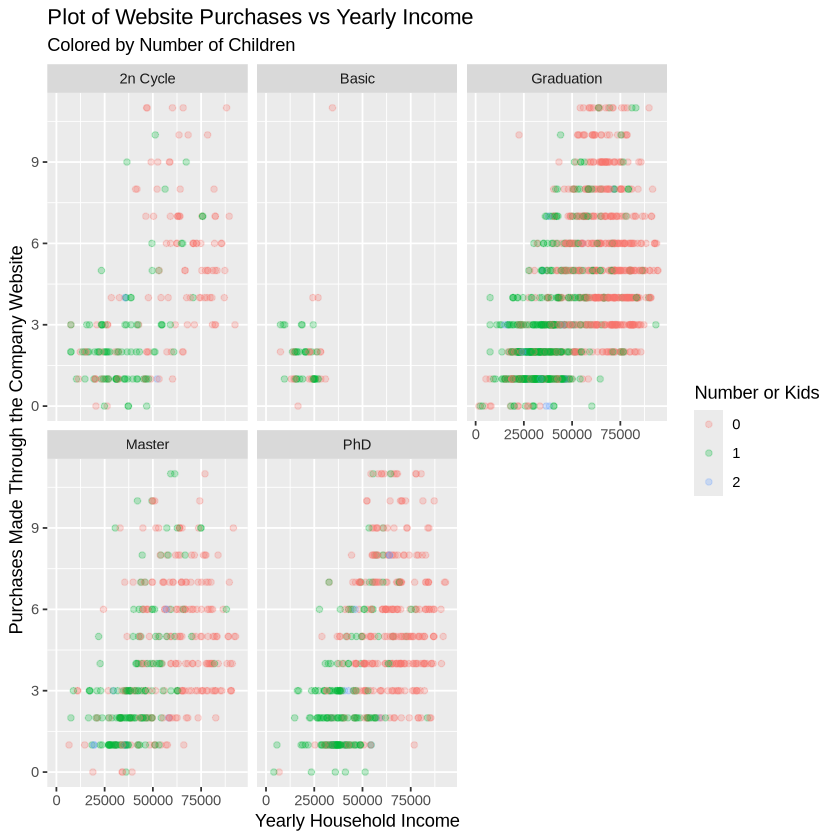

In [3]:
# Creating a Scatterplot of NumWebPurchases vs Income Faceted by Kidhome
p1 <- ggplot(marketing_df, aes(x = Income, y = NumWebPurchases, color = as.factor(Kidhome))) +
geom_point(alpha=0.25) +
facet_wrap(~ Education) +
xlim(0,quantile(marketing_df$Income, 0.99, na.rm = TRUE)) +  # Limit Income Values to the 99th quantile To Prevent Outliers Making the Graph Small and Unreadable
ylim(0,quantile(marketing_df$NumWebPurchases, 0.99, na.rm = TRUE)) + # Limit NumWebPurchases Values to the 99th quantile To Prevent Outliers Making the Graph Small and Unreadable
xlab("Yearly Household Income") +
ylab("Purchases Made Through the Company Website") +
scale_color_discrete(name = "Number or Kids") + 
ggtitle("Plot of Website Purchases vs Yearly Income", subtitle = "Colored by Number of Children")

  

# Combine the plots using cowplot
# combined_plot <- plot_grid(p1, p2, labels = "AUTO")

# Display the combined plot
print(p1)

The scatterplot allows us to visually explore how the demographic factors used in the plot might influence purchasing habits. While there is not much data for PHDs, making the trends in the plot somewhat unclear, we can see that the number of web purchases scales positively with yearly income. In addition, we can see in general income and the number of purchases go down as the number of kids a customer has goes up. 

<!-- END QUESTION -->

<br><br><br><br>

# Question Modification

I am modifying the question in the first part of the individual assignment to focus solely on prediction. In addition, besides the two variables `Z_CostContact` and `Z_Revenue` that I mentioned will not be used, I will also eliminate the variable `ID` since it should not have an effect on the response, as well as the variable `Dt_Customer` as we have not yet learned to work with dates.

# Methods and Plan

## Choice of Model

In order to address my question of interest, I believe that using a Poisson regression model is appropriate as the model is used for predicting counts, and the variable we want to predict indicates the count of the purchases made online. The assumptions made when using this model are that the response variable `NumWebPurchases` follows a poisson distribution. Also, the mean of the response variable should equal its variance. We also assume that the purchasing habits of one customer do not affect the habits of another customer.

## Limitations/Weaknesses of Model Choice

With respect to limitations/weaknesses, it is possible for poisson regression to return a negative count value which does not really make sense in the context of number of online purchases. In addition, if the variance is higher than expected, overdispersion may occur. 

# Computational Code and Output

In [4]:
# For this individual submission, I am not going to perform variable selection
# Create and Fit the Model, Display Tidied Results
model_data <- marketing_df %>%
dplyr::select(-ID, -Dt_Customer, -Z_CostContact, -Z_Revenue)  # Removing unnecessary variables 
                                                                   
poisson_model <- glm(NumWebPurchases ~ ., data = model_data, family = poisson) # Creating Poisson Regression model
tidy_poisson <- poisson_model %>%     # Tidy Result Data to View Model P-Values                                       
tidy() 
tidy_poisson

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.623225e+00,1.980306e+00,1.3246566,1.852851e-01
Year_Birth,-1.397915e-03,9.806917e-04,-1.4254379,1.540307e-01
EducationBasic,-2.430361e-01,1.071418e-01,-2.2683586,2.330736e-02
EducationGraduation,3.764184e-02,3.994531e-02,0.9423344,3.460215e-01
EducationMaster,3.073290e-02,4.654082e-02,0.6603429,5.090338e-01
EducationPhD,7.192152e-02,4.535017e-02,1.5859151,1.127586e-01
Marital_StatusAlone,7.469367e-01,4.621061e-01,1.6163748,1.060133e-01
Marital_StatusDivorced,2.953924e-01,3.836669e-01,0.7699187,4.413481e-01
Marital_StatusMarried,3.213636e-01,3.825969e-01,0.8399533,4.009346e-01


## Interpretations

From the table above, we can see that there there are 22 variables (including the base intercept itself) that have p-values greater than 0.05, which means that we cannot conclude that they have any significant effect in predicting the response. This suggests the inclusion of irrelevant variables as inputs may be occurring which may conceal meaningful relationships. In addition, if the variance is greater than the mean overdispersion might also be occurring which violates an assumption made when using poison regression. Hence, variable selection methods as well as a quasipoission model should both be explored to improve the models accuracy.